# Exploratory Data Analysis

Plan:

- For each subtask we have training, validation and test sample sets with code, language, label and generator.
- We want to find interesting information about each programming language to see if we should treat the separately or if they are informative piece of data.
- We will use simple metrics to see if they are significant differences between them or not.
- After analysis we will get some conclusions

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("SemEval-2026-Task13")
dir_paths = {name: path / f"task_{name}" for name in ["a", "b", "c"]}
datasets = {
    name: {
        "training": dir_paths[name] / f"task_{name}_training_set.parquet"
        if name == "b"
        else dir_paths[name] / f"task_{name}_training_set_1.parquet",
        "validation": dir_paths[name] / f"task_{name}_validation_set.parquet",
        "test": dir_paths[name] / f"task_{name}_test_set_sample.parquet",
    }
    for name in ["a", "b", "c"]
}

data = pd.read_parquet(datasets["b"]["training"])
print(data.head())
data["word_count"] = data["code"].str.split().str.len()

                                                code generator  label language
0  def load(config, filepath, token):\n    if con...     Human      0   Python
1  n = int(input())\narr = list(map(int, input()....     Human      0   Python
2  using Aow.Infrastructure.Domain;\nusing Aow.In...    GPT-4o     10       C#
3  def save_data(bot, force=False):\n    if bot.d...     Human      0   Python
4  def parse_metadata(metaurl, progress=1e5):\n  ...     Human      0   Python


In [2]:
data_cut = data.head(10_000)
words = (
    data_cut.assign(word=data_cut["code"].str.lower().str.replace(r"[^a-z0-9_]", " ", regex=True).str.split())
        .explode("word")
        .dropna(subset=["word"])
)

words = words[words["word"].str.strip() != ""]

top_words = (
    words.groupby(["language", "word"])
         .size()
         .reset_index(name="count")
)

top5 = (
    top_words.sort_values(["language", "count"], ascending=[True, False])
             .groupby("language")
             .head(5)
)

print(top5)

          language      word  count
4664             C        if   1603
0                C         0   1380
107              C         1   1046
8572             C    return   1024
4856             C       int    903
25487           C#    public   3937
20152           C#        if   2864
23453           C#       new   2575
26470           C#    return   2547
28266           C#    string   2515
36512          C++         i   3570
36864          C++       int   3068
30922          C++         0   2983
31083          C++         1   2187
36580          C++        if   2164
46526           Go       err   2441
47831           Go        if   1983
50896           Go    return   1885
49529           Go       nil   1616
47094           Go      func   1165
85778         Java    public   9974
95026         Java       the   9472
88100         Java    return   8640
93444         Java    string   8297
73858         Java        if   7997
110524  JavaScript      this   2690
102246  JavaScript     const

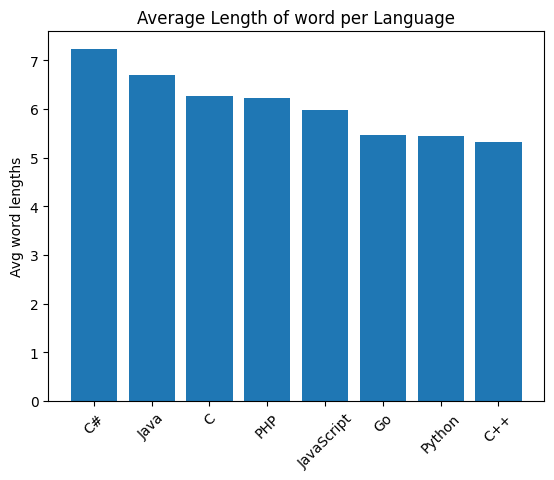

In [3]:
words = words.assign(word_length=words["word"].str.len())

avg_word_length = (
    words.groupby("language")["word_length"]
         .mean()
         .reset_index(name="avg_word_length")
         .sort_values("avg_word_length", ascending=False)
)

avg_word_length["avg_word_length"] = avg_word_length["avg_word_length"].round(2)
plt.bar(avg_word_length["language"], avg_word_length["avg_word_length"])
plt.xticks(rotation=45)
plt.title("Average Length of word per Language")
plt.ylabel("Avg word lengths")
plt.show()


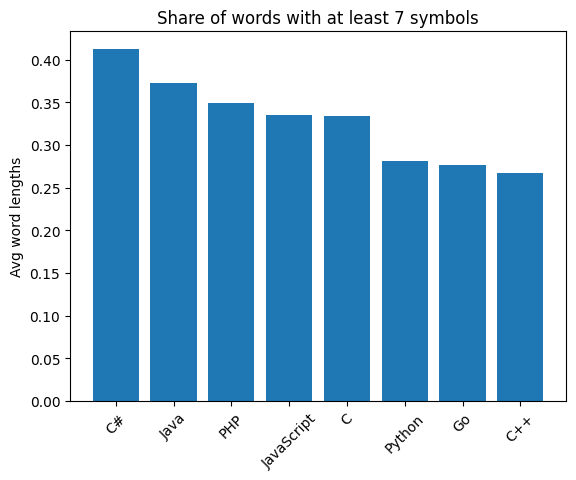

In [4]:
words = words.assign(word_length=words["word"].str.len())

words = words.assign(is_4plus = words["word_length"] >= 7)

avg_nplus = (
    words.groupby("language")["is_4plus"]
         .mean()
         .reset_index(name="avg_share_nplus")
         .sort_values("avg_share_nplus", ascending=False)
)

plt.bar(avg_nplus["language"], avg_nplus["avg_share_nplus"])
plt.xticks(rotation=45)
plt.title("Share of words with at least 7 symbols")
plt.ylabel("Avg word lengths")
plt.show()

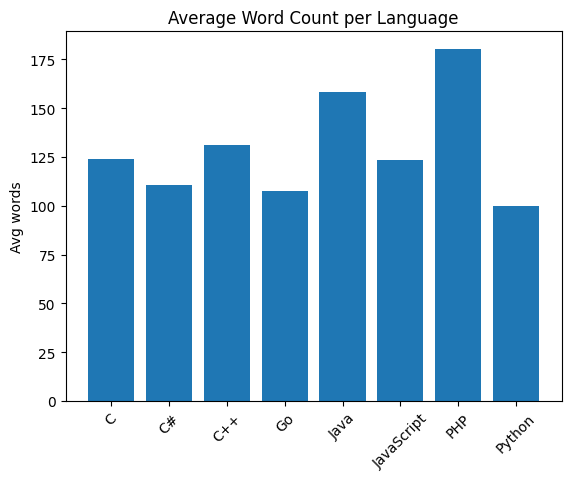

In [5]:
avg_words = data.groupby("language")["word_count"].mean().reset_index()

plt.bar(avg_words["language"], avg_words["word_count"])
plt.xticks(rotation=45)
plt.title("Average Word Count per Language")
plt.ylabel("Avg words")
plt.show()

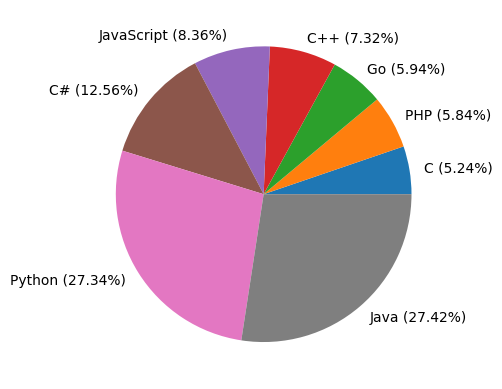

In [ ]:
language_count = data.groupby("language").count().sort_values("code")
total = language_count['code'].sum()
labels = [f'{name} ({value/total*100:.2f}%)' for name, value in zip(language_count.index, language_count.code)]
plt.pie(language_count['code'], labels=labels)
plt.show()

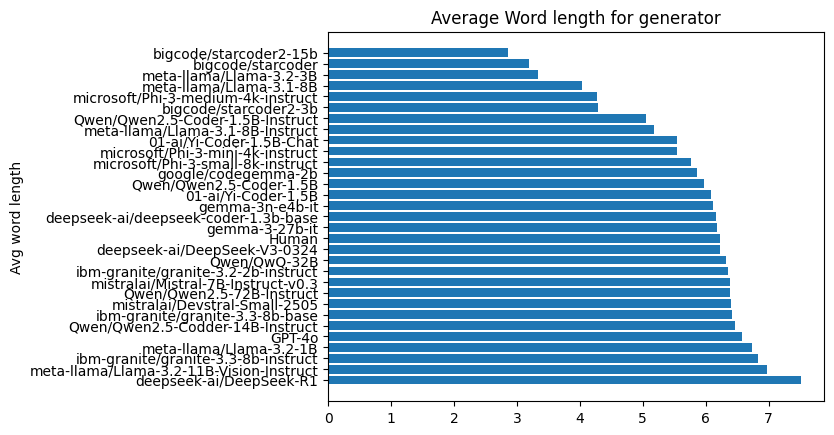

In [7]:
words = words.assign(word_length=words["word"].str.len())

avg_word_length_gen = (
    words.groupby("generator")["word_length"]
         .mean()
         .reset_index(name="avg_word_length")
         .sort_values("avg_word_length", ascending=False)
)

plt.barh(avg_word_length_gen["generator"], avg_word_length_gen["avg_word_length"])
plt.title("Average Word length for generator")
plt.ylabel("Avg word length")
plt.show()

## Conclusions

Basic metrics showed that there is visible difference between language when it comes to average number of words or just a number of words in code snippet.

Because of size of dataset, it was more reasonable to load one dataset at a time and python garbage collection is debatable, so graphs from above won't tell all information gathered because of this EDA, try changing the dataset parameter from above to see how where the counts in other datasets.

But in summary we can see:
- In dataset A human used wrote smaller words than AI models
- Many languages have different word count and word lengths than other so it would be reasonable to use this information later on
- The average lengths of words used by different generators is valuable information, so if we would get large enough batches of code where each batch has the same generator we should be able to with relatively high accuracy determine what generator was used
- Different languages uses different vocabulary, so there are different popular words